In [1]:
# Import necessary packages
import numpy as np
from math import pi
from matplotlib import pyplot as plt
from basic_mueller import *
from scipy.io.wavfile import write
from scipy.signal import resample

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

# Set up some constants for the figures and simulations
figsize = (16., 9.)
numpts = 1000

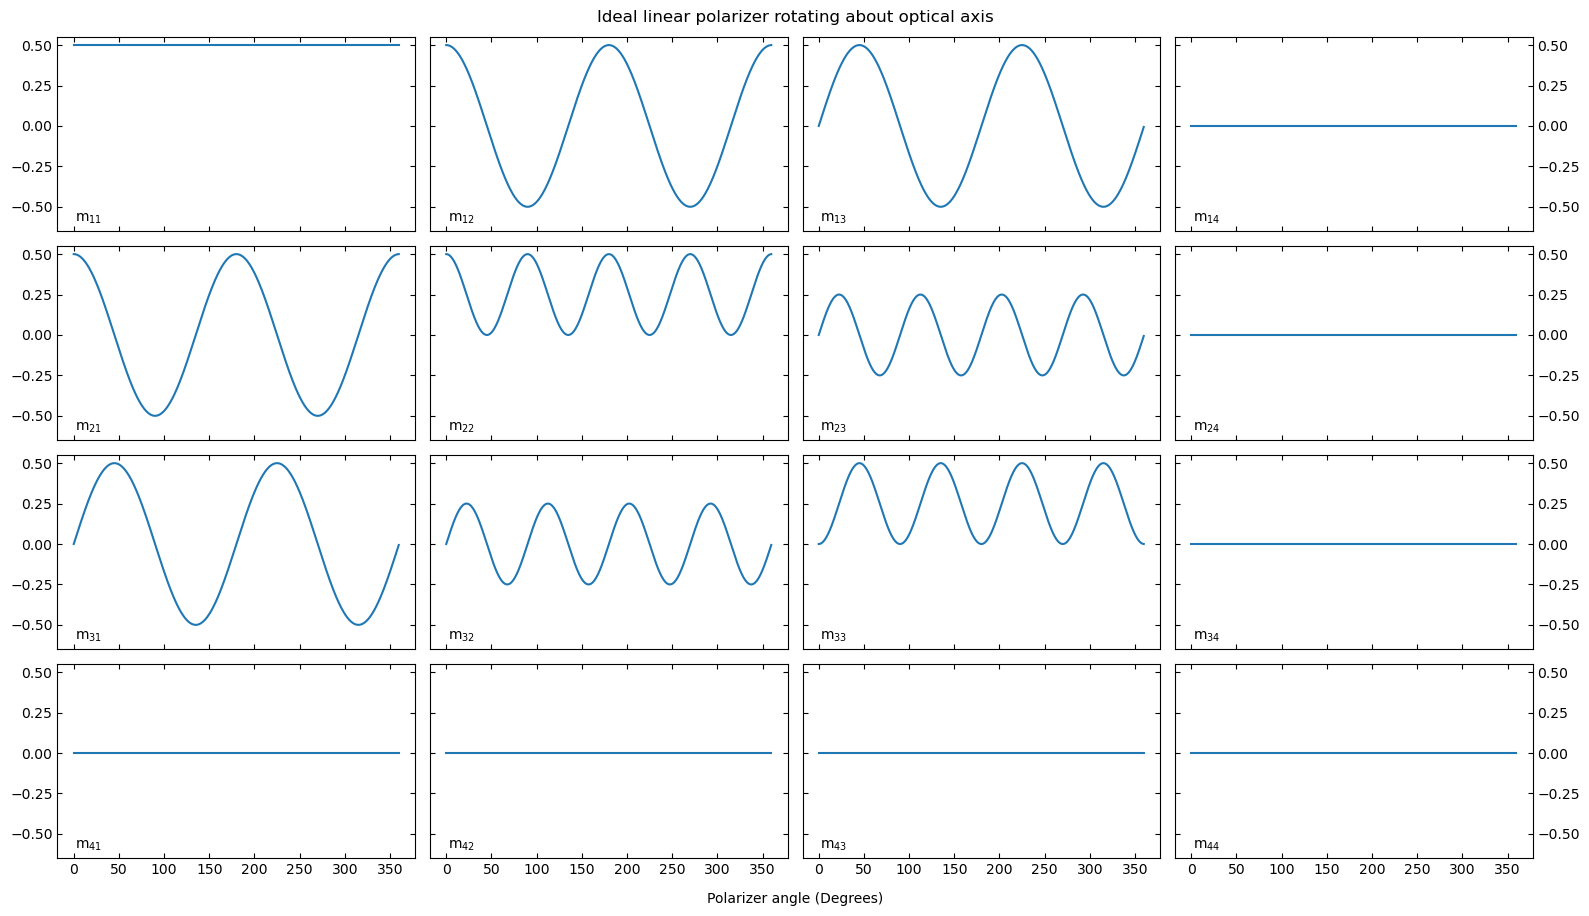

In [2]:
# Basic component plots - Rotating linear polarizer
theta = np.linspace(0., 360., numpts, endpoint=False)
polarizer = ideal_linear_polarizer(theta)

fig, ax = plot_mueller(polarizer, theta, title="Ideal linear polarizer rotating about optical axis")
_ = fig.text(0.5, 0, 'Polarizer angle (Degrees)', ha='center', va='top')
_ = fig.set_size_inches(figsize)
_ = plt.tight_layout()

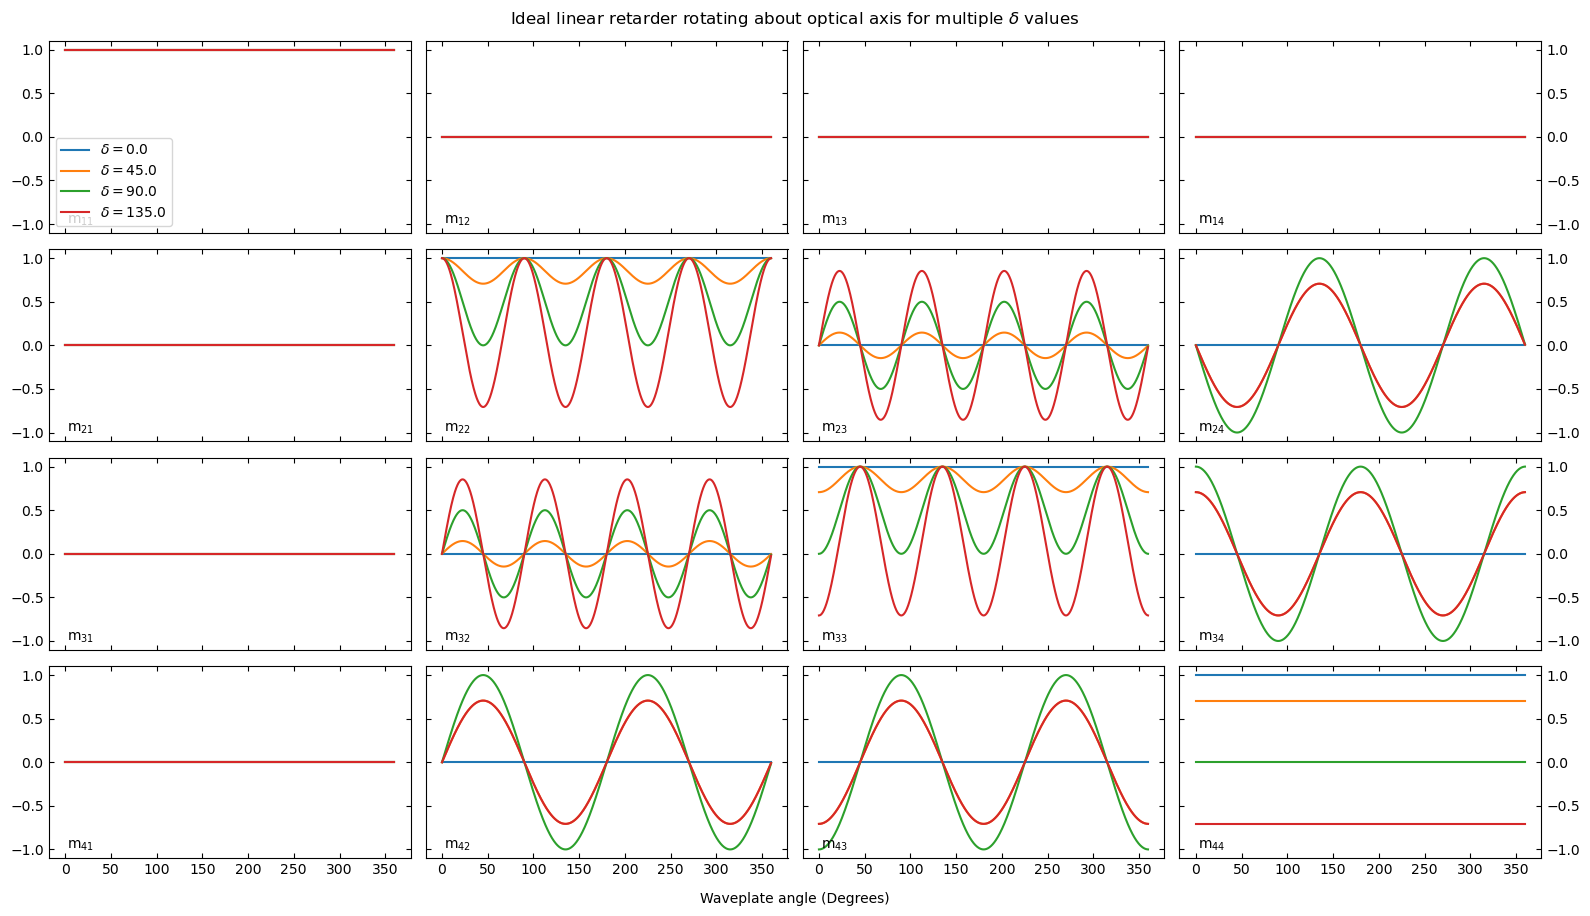

In [3]:
# Basic component plots - Rotating linear retarder
theta = np.linspace(0, 360, numpts, endpoint=False)
delta_vals = [0., 45., 90., 135.]

retarder = ideal_linear_retarder(delta=delta_vals[0], theta=theta)
fig, ax = plot_mueller(retarder, theta,
                       title="Ideal linear retarder rotating about optical axis for multiple $\delta$ values")
for dv in delta_vals[1:]:
    retarder = ideal_linear_retarder(delta=dv, theta=theta)
    fig, ax = plot_mueller(retarder, theta, figax=(fig, ax))

    legend = []
for dv in delta_vals:
    legend.append("$\delta=" + "{:.1f}".format(dv) + "$")
for i in range(4):
    for j in range(4):
        ax[i, j].set_ylim(-1.1, 1.1)
_ = ax[0][0].legend(legend)
_ = fig.text(0.5, 0, 'Waveplate angle (Degrees)', ha='center', va='top')
_ = fig.set_size_inches(16, 9)
_ = plt.tight_layout()

Alpha:	0.00000000
Beta:	-0.98480775
Psi:	45.0000
Delta:	170.0000


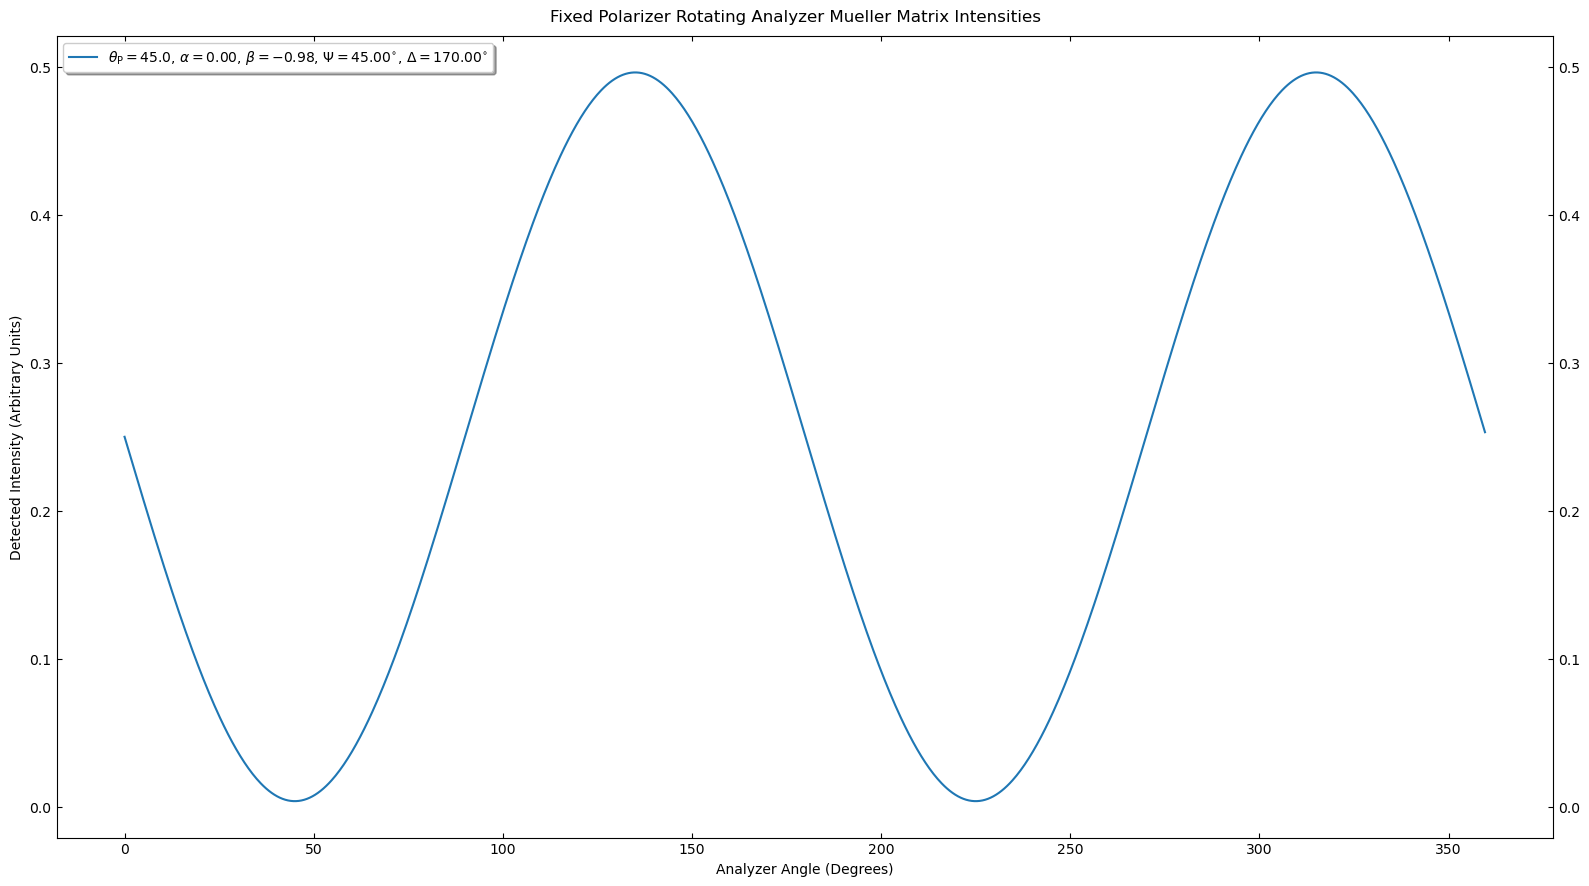

In [4]:
# Fixed polarizer, rotating analyzer Psi-Delta example
theta_a_vals = np.linspace(0., 360., numpts, endpoint=False)
theta_p = 45.
sample_psi = 45.
sample_delta = 170.

# Generate intensity
analyzer = ideal_linear_polarizer(theta_a_vals)
intensity = analyzer @ ideal_ncs(sample_psi, sample_delta) @ ideal_linear_polarizer(theta_p)
intensity = intensity[..., 0, 0]
# Determine Fourier coefficients
intensity_freqs = np.fft.rfft(intensity)
# Normalize by one half of the DC component
intensity_freqs /= 0.5 * intensity_freqs[0]
# Copy the 2Hz coefficients
alpha = intensity_freqs[2].real
beta = -intensity_freqs[2].imag
# Compute Psi and Delta from Fourier coefficients alpha and beta
tan_psi = np.sqrt((1. + alpha) / (1. - alpha)) * np.abs(np.tan(np.deg2rad(theta_p)))
cos_delta = beta / np.sqrt(1. - np.square(alpha))
psi = np.rad2deg(np.arctan(tan_psi))
delta = np.rad2deg(np.arccos(cos_delta))

# Show the results
print("Alpha:\t{:.8f}\r\nBeta:\t{:.8f}".format(alpha, beta))
print("Psi:\t{:.4f}\r\nDelta:\t{:.4f}".format(psi, delta))
fig, ax = plt.subplots()
fig.set_size_inches(figsize)
ax.plot(theta_a_vals, intensity)
ax_legend = []
ax_legend.append('$\\theta_{{\\mathrm{{P}}}}={{{}}}$'.format(theta_p))
ax_legend[0] += ', $\\alpha={{{:.2f}}}$'.format(alpha)
ax_legend[0] += ', $\\beta={{{:.2f}}}$'.format(beta)
ax_legend[0] += ', $\\Psi={{{:.2f}}}^{{\circ}}$'.format(psi)
ax_legend[0] += ', $\\Delta={{{:.2f}}}^{{\circ}}$'.format(delta)
ax.tick_params(**intensity_tick_kwargs())
ax.set_xlabel('Analyzer Angle (Degrees)')
ax.set_ylabel('Detected Intensity (Arbitrary Units)')
fig.suptitle('Fixed Polarizer Rotating Analyzer Mueller Matrix Intensities')
ax.legend(ax_legend, loc='upper left', fancybox=True, shadow=True)
plt.tight_layout()

Text(0.5, 0, 'Sample number n')

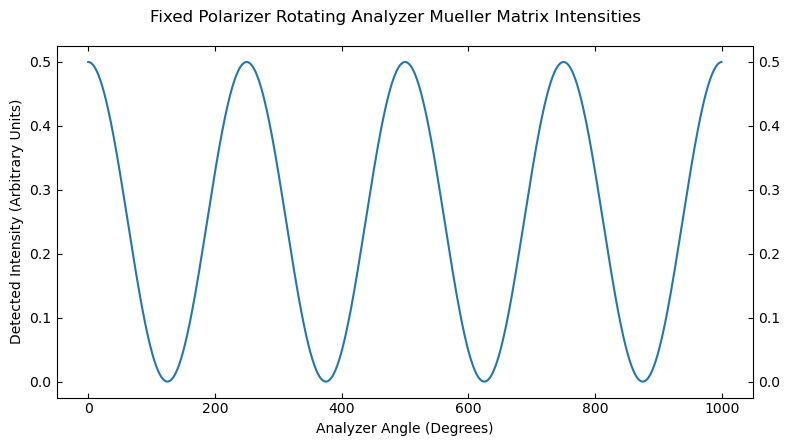

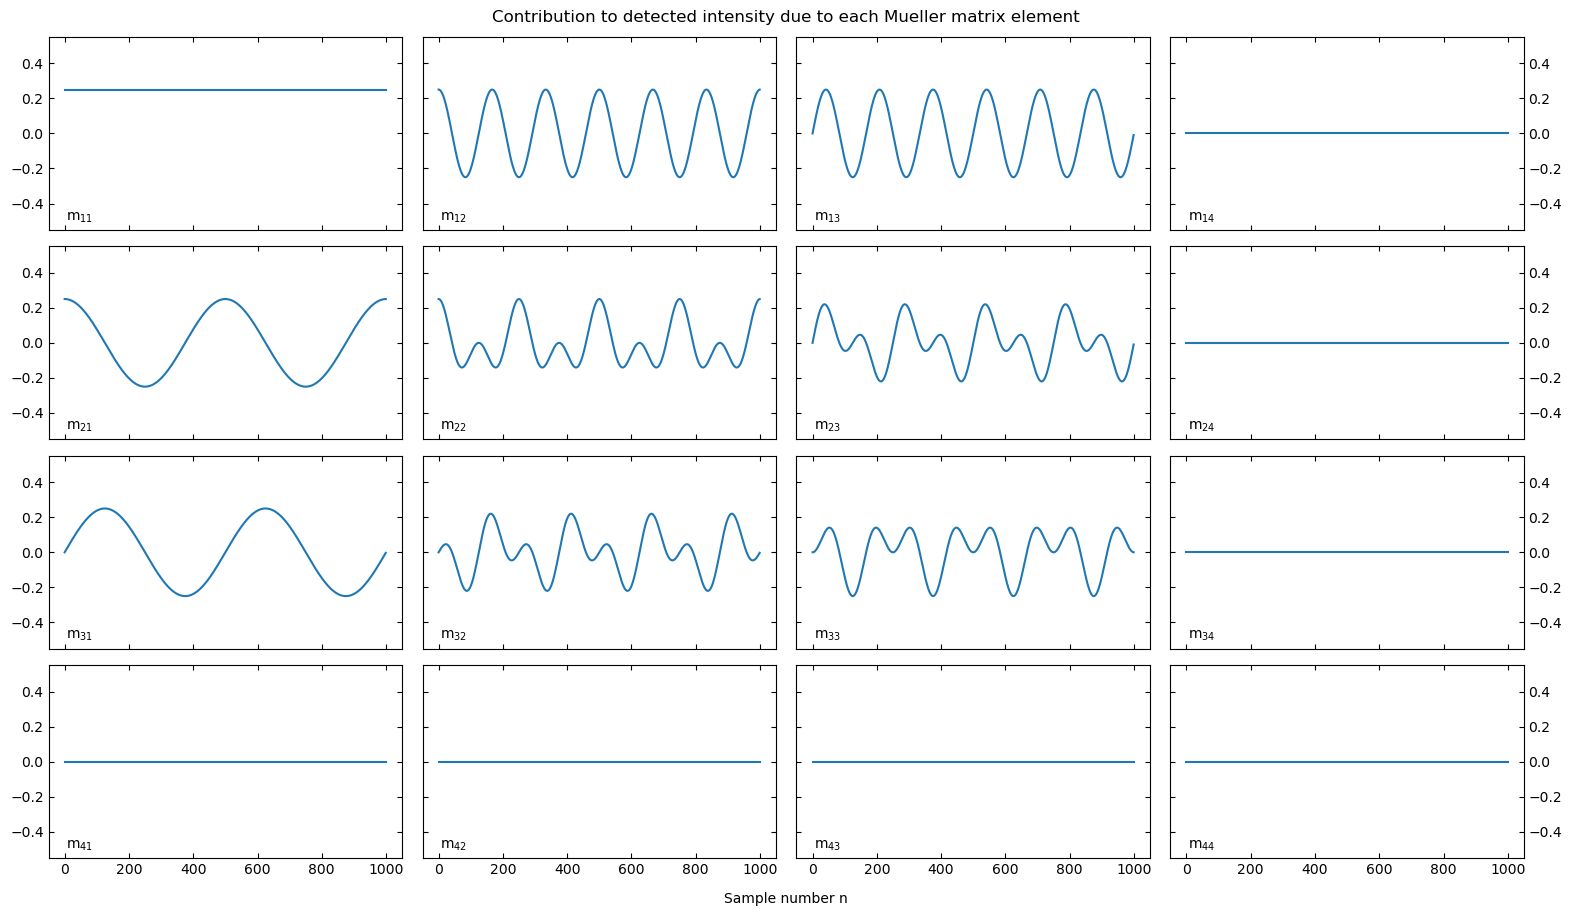

In [5]:
# Rotating polarizer, rotating analyzer Mueller matrix example

theta_a_vals = np.linspace(0, 360, numpts, endpoint=False)
theta_p_vals = np.linspace(0, 360 * 3, numpts, endpoint=False)

analyzer = ideal_linear_polarizer(theta_a_vals)
polarizer = ideal_linear_polarizer(theta_p_vals)
ax_legend = []
fig, ax = plt.subplots()
fig.set_size_inches(8, 4.5)
intensity = analyzer @ polarizer
intensity = intensity[..., 0, 0]
ax.plot(intensity)
ax.tick_params(**intensity_tick_kwargs())
ax.set_xlabel('Analyzer Angle (Degrees)')
ax.set_ylabel('Detected Intensity (Arbitrary Units)')
fig.suptitle('Fixed Polarizer Rotating Analyzer Mueller Matrix Intensities')
plt.tight_layout()

eqns = np.zeros([numpts, 4, 4])
for row in range(4):
    for col in range(4):
        temp_mm = np.zeros((4, 4))
        temp_mm[row, col] = 1.0
        intensity = analyzer @ temp_mm @ polarizer
        eqns[..., row, col] = intensity[..., 0, 0]

fig, ax = plot_mueller(eqns)
for i in range(4):
    for j in range(4):
        ax[i, j].set_ylim(-0.55, 0.55)
fig.set_size_inches(16, 9)
fig.suptitle('Contribution to detected intensity due to each Mueller matrix element')
plt.tight_layout()
fig.text(0.5, 0, 'Sample number n', ha='center', va='top')
# fig.text(0., 0.5, 'common Y', ha='left', va='center', rotation='vertical')

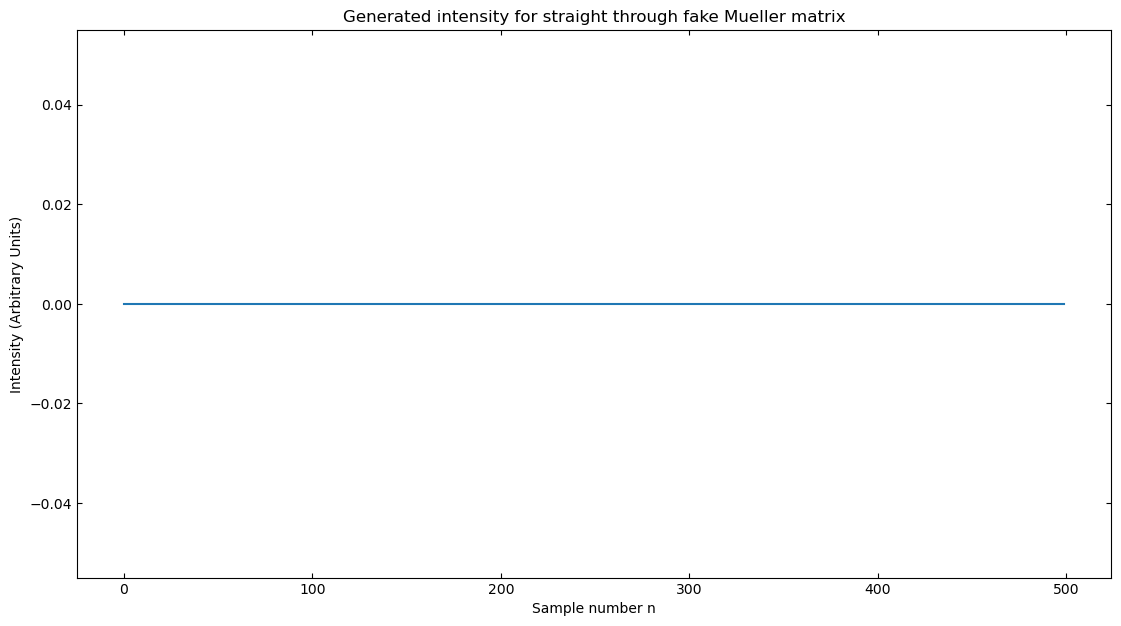

In [6]:
# Rotating polarizer, rotating analyzer Mueller matrix example
npts = 500

theta_a_vals = np.linspace(0, 360, npts, endpoint=False)
theta_p_vals = np.linspace(0, 360 * 3, npts, endpoint=False)

analyzer = ideal_linear_polarizer(theta_a_vals)
polarizer = ideal_linear_polarizer(theta_p_vals)

bs_mm = np.eye(4)
bs_mm *= 0.
bs_mm[3, 3] = 1.0

intensity = analyzer @ bs_mm @ polarizer
intensity = intensity[..., 0, 0]

fig, ax = plt.subplots()
fig.set_size_inches(16 * 0.707, 9 * 0.707)
ax.plot(intensity)
ax.tick_params(which='both', direction='in', labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               left=True, right=True, bottom=True, top=True)
ax.set_title('Generated intensity for straight through fake Mueller matrix')
ax.set_ylabel('Intensity (Arbitrary Units)')
ax.set_xlabel('Sample number n')
plt.tight_layout()

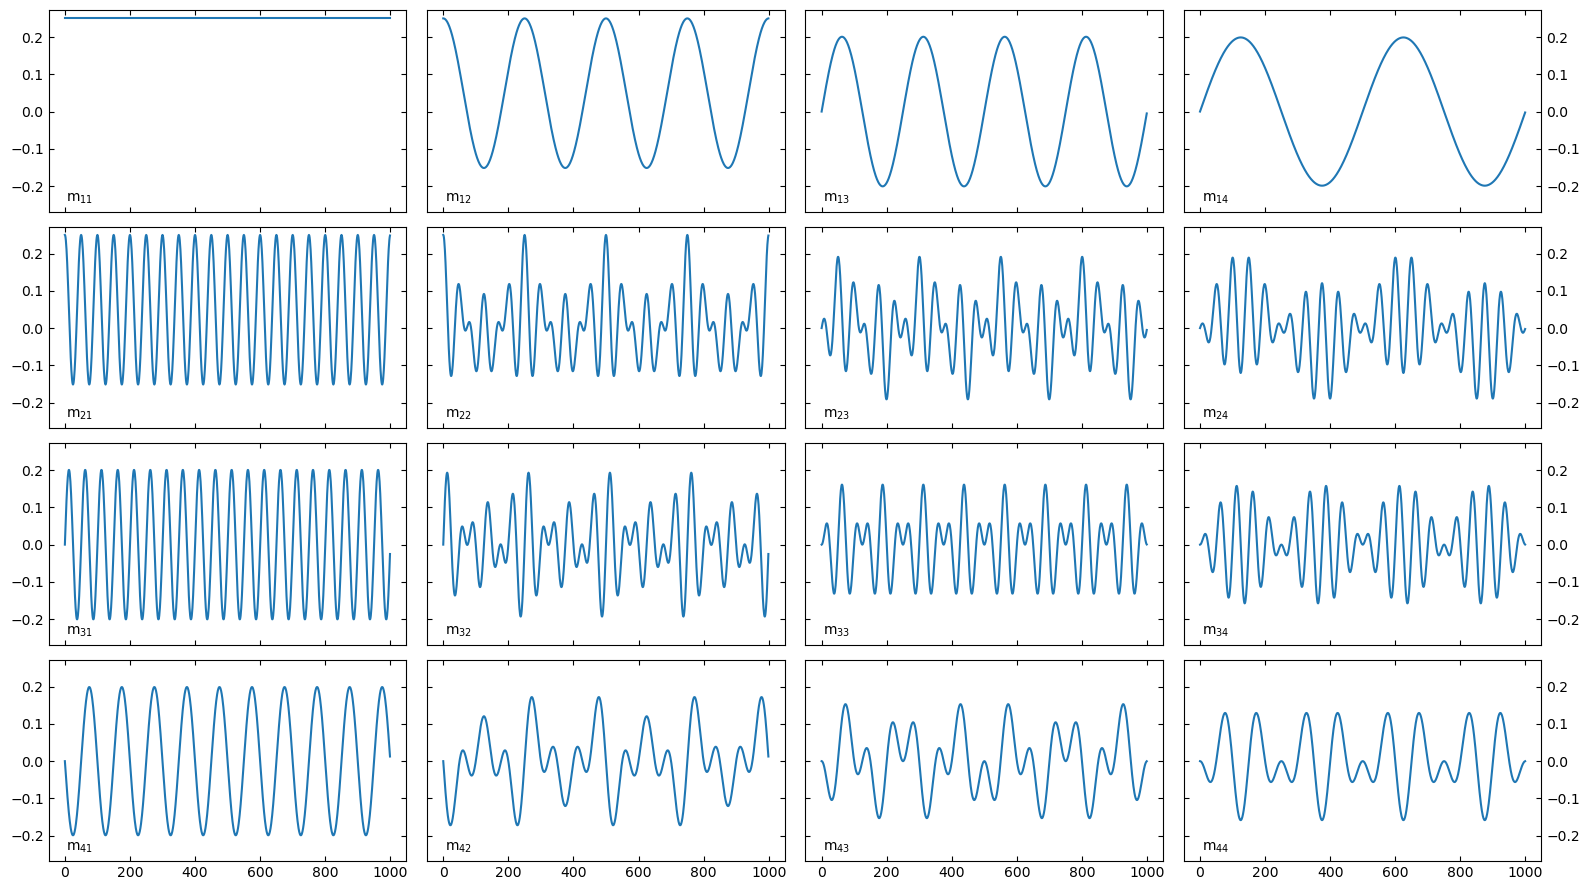

In [7]:
# Setting up the system of equations

c1_revs = 1
c2_revs = 5
# delta_c1 = 90.
delta_c1 = 90. * np.sqrt(2)
delta_c2 = delta_c1
theta_p = 0.
theta_c1 = np.linspace(0., c1_revs * 360., numpts, endpoint=False)
theta_c2 = np.linspace(0., c2_revs * 360., numpts, endpoint=False)
theta_a = 0.

# fundamental = 49

polarizer = ideal_linear_polarizer(theta=theta_p)
c1 = ideal_linear_retarder(delta=delta_c1, theta=theta_c1)
c2 = ideal_linear_retarder(delta=delta_c2, theta=theta_c2)
analyzer = ideal_linear_polarizer(theta=theta_a)

sample_mm = np.eye(4)

intensity = analyzer @ c2 @ sample_mm @ c1 @ polarizer
intensity = intensity[..., 0, 0]

# Set up linear system of equations
eqns = np.zeros([numpts, 4, 4])
for row in range(4):
    for col in range(4):
        temp_mm = np.zeros((4, 4))
        temp_mm[row, col] = 1.0
        intensity = analyzer @ c2 @ temp_mm @ c1 @ polarizer
        eqns[..., row, col] = intensity[..., 0, 0]
        
fig, ax = plot_mueller(eqns)
fig.set_size_inches(16, 9)
plt.tight_layout()

In [8]:
# Solving the system of equations

new_eqns = np.asarray(eqns)
new_eqns.shape=(numpts, 16)

pseudo_inv = np.linalg.inv(new_eqns.T @ new_eqns) @ new_eqns.T

# sample_mm = np.eye(4)
sample_mm = ideal_linear_polarizer(0.)
# sample_mm = ideal_linear_retarder(delta=90., theta=0.)

air_intensity = analyzer @ c2 @ sample_mm @ c1 @ polarizer
air_intensity = air_intensity[..., 0, 0]
# air_intensity += 0.1 * np.random.randn(air_intensity.size).reshape(air_intensity.shape)
determined_mm = pseudo_inv @ air_intensity
determined_mm.shape=(4, 4)

print(determined_mm)

[[ 5.00000000e-01  5.00000000e-01 -7.31699934e-17  3.37314262e-17]
 [ 5.00000000e-01  5.00000000e-01 -1.43131840e-16 -1.62923288e-16]
 [ 1.09188979e-17 -8.15175188e-17 -6.76539182e-17 -2.09045600e-17]
 [ 6.50455881e-17 -2.16349351e-16  1.12751081e-16  4.04281471e-17]]
